# First order methods on regression models

    Lab 2 : Optimization for Machine Learning, AMMI Master's in Machine Intelligence

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT


- **Each** student must send their jupyter notebook solutions **before the 8th of February at 23:55**  to **gowerrobert@gmail.com**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [10]:
# Change here using YOUR first and last names
fn1 = "Irene Raissa"
ln1 = "KAMENI KAMENI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1])) + ".ipynb"
print(filename)

lab1_kameni kameni_irene raissa.ipynb


In [11]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

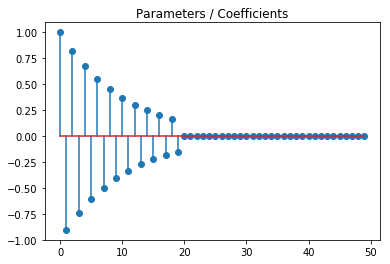

In [13]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [14]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + randn(n_samples)
    return A, b

def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))

def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + g(z) \right\}.
$$


We have in mind to use the following cases

- Ridge penalization, where $g(z) = \frac{s}{2} \|z\|_2^2$
- Lasso penalization, where $g(z) = s \|z|\|_1$

where $s \geq 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 
    </li>
    </ul>
</div>

In [15]:
def prox_lasso(x, s):
    """Proximal operator for the Lasso at x""" 
    prox=np.ones(len(x))
    for i in range(len(x)):
        if x[i]>s:
            prox[i]=x[i]-s
        elif x[i]<-s:
            prox[i]=x[i]+s
        else:
            prox[i]=0
    
    return prox # TODO
    
def lasso(x,s):
    """Value of the Lasso penalization at x"""
    lasso=s * abs(x).sum()
    
    return lasso # TODO

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x""" 
    z=x/(s+1)
    return z # TODO
    
def ridge(x, s):
    """Value of the ridge penalization at x"""
    ridge=s * x.T @ x/2
    
    return ridge # TODO

# Proxy with one line of code

In [16]:
def proxylasso_(x,s):
    """Value of the Lasso penalization at x"""
    #proxy=np.ones(len(x))
    #for i in range(len(x)):
    proxy=np.sign(x) * (np.maximum(np.zeros(len(x)), np.abs(x)-s))
    
    return proxy # TODO 

In [17]:
np.array([1,2,3,5]) / np.array([2,-1,6,9])

array([ 0.5 , -2.  ,  0.5 ,  0.56])

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

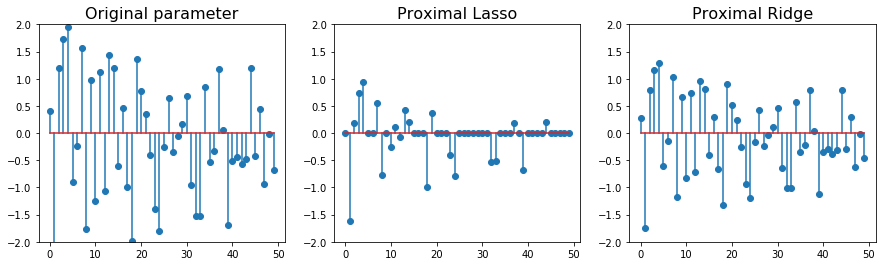

In [18]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])


<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

Lasso look better than Ridge because it converge more faster

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [19]:
def loss_linreg(x):
    return 0.5 * norm(b - A.dot(x)) ** 2 / n_samples

def grad_linreg(x):
    """Leas-squares gradient"""
    grad=-(A.T @ (b- (A @ x))) /n_samples
    # TODO
    return grad

def loss_logreg(x):
    u = b * A.dot(x)
    return np.sum(np.log(1 + np.exp(-u))) / n_samples

def grad_logreg(x):
    """Logistic gradient"""
    
    grad=0
    for i in range(len(A)):
        grad+= -b[i]* A[i]/  (1+np.exp(b[i]* A[i] @ x ))
    return grad/n_samples

# TO BE COMPLETED

In [20]:
from scipy.optimize import check_grad

In [21]:
A,b=simu_linreg(coefs, n_samples=1000, corr=0.5)
print(check_grad(loss_linreg, grad_linreg, x  ))
A,b =simu_logreg(coefs, n_samples=1000, corr=0.5)
print(check_grad(loss_logreg, grad_logreg, x ))

2.7856573339769475e-06
1.8663184948230724e-07


## Part 3: Solvers

We now have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `ista` below that implements the 
  ISTA (Proximal Gradient Descent) algorithm</li>
    <li> BONUS QUESTION:  Implement FISTA (Accelerated Proximal 
  Gradient Descent) algorithm as described at the bottom
    </ul>
</div>

In [22]:
# TO BE COMPLETED

def lip_linreg(A):
    """Lipschitz constant for linear squares loss""" 
    const= (np.linalg.norm(A))**2/ n_samples
    # TODO
    return  const
    
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    # TODO
    
    #u= 1/ 1+ np.exp(-B)
    const=np.linalg.norm( A)**2/(4*n_samples)
    return const
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print("Lauching ISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        x_new= prox_g( x - (grad_f(x)* step), s*step)
        x=x_new
        
        #### TODO ####
        
        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

Try and implement the FISTA algorithm (detailed in maths below)

FISTA Algorithm:
$$\begin{array}{l}
\mbox{Set } w^1=0=z^1, \beta^1 =1\\
\mbox{for }t=1,2,3, \ldots, T \quad  \\
\qquad \displaystyle w^{t+1} = \mbox{prox}_{\left. \lambda R \right/ \mathcal{L}}\left( z^t - \frac{1}{\mathcal{L}} \nabla L(z^t)\right) \\
\qquad \displaystyle \beta^{t+1} = \frac{1+\sqrt{1+4(\beta^t)^2}}{2}\\
\qquad \displaystyle  z^{t+1} = w^{t+1} + \frac{\beta^t -1}{\beta^{t+1}} (w^{t+1} -w^{t})\\
\mbox{Output } w^{T+1}
\end{array}$$

In [23]:
# TO BE COMPLETED

def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print("Lauching FISTA solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        
        x_new= prox_g(z - (grad_f(z)* step ), s*step )
           
        t_new=(1+ np.sqrt(1+ 4 * (t**2)))/2
        
        z=x_new + (( (t-1)/ t_new)* (x_new-x))
        
        x=x_new
        t=t_new
        
              

        #### TODO ####

        obj = f(x) + g(x, s)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

In [24]:
# f=loss_linreg
# g=lasso
# grad_f=grad_linreg
# prox_g=prox_lasso
# step= 1/lip_linreg(A)
# #fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=1000, x_true=coefs, verbose=True)

# _, obji, err_ista=fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=1000, x_true=coefs, verbose=True)
# _, objf, err_fista=ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=1000, x_true=coefs, verbose=True)

In [25]:
# plt.plot(err_ista, label='err_ista')
# plt.plot(err_fista, label='err_fista')
# plt.legend()
# plt.yscale('log')

## Algorithms comparison and numerical experiments

In [26]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 40
s = 1e-2

In [27]:
f=loss_linreg
g=ridge
grad_f=grad_linreg
prox_g=prox_ridge
step=1/lip_linreg(A)
#fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=1000, x_true=coefs, verbose=True)

_, obji, err_ista=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, objf, err_fista=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 4.97e-01 | 9.97e-01
      10 | 4.72e-01 | 9.72e-01
      20 | 4.53e-01 | 9.48e-01
      30 | 4.38e-01 | 9.27e-01
      40 | 4.26e-01 | 9.07e-01
      50 | 4.15e-01 | 8.89e-01
      60 | 4.07e-01 | 8.73e-01
      70 | 4.00e-01 | 8.58e-01
      80 | 3.93e-01 | 8.44e-01
      90 | 3.88e-01 | 8.30e-01
     100 | 3.84e-01 | 8.18e-01
     110 | 3.80e-01 | 8.07e-01
     120 | 3.76e-01 | 7.97e-01
     130 | 3.73e-01 | 7.87e-01
     140 | 3.71e-01 | 7.78e-01
     150 | 3.69e-01 | 7.70e-01
     160 | 3.67e-01 | 7.62e-01
     170 | 3.65e-01 | 7.55e-01
     180 | 3.64e-01 | 7.48e-01
     190 | 3.63e-01 | 7.42e-01
     200 | 3.62e-01 | 7.36e-01
     210 | 3.61e-01 | 7.31e-01
     220 | 3.60e-01 | 7.26e-01
     230 | 3.59e-01 | 7.21e-01
     240 | 3.58e-01 | 7.16e-01
     250 | 3.58e-01 | 7.12e-01
     260 | 3.57e-01 | 7.09e-01
     270 | 3.57e-01 | 7.05e-01
     280 | 3.57e-01 | 7.02e-01
     290 | 3.56e-01 | 6.99e-01
     300 | 3.56

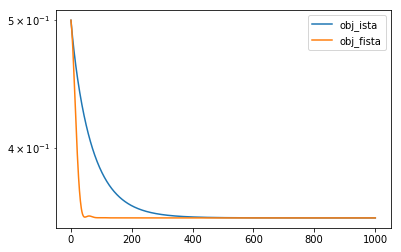

In [28]:
plt.plot(obji, label='obj_ista')
plt.plot(objf, label='obj_fista')
plt.legend()
plt.yscale('log')

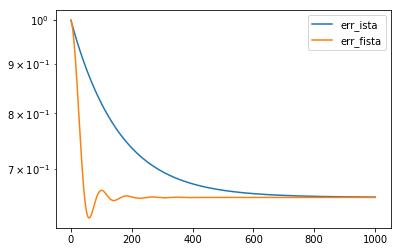

In [29]:
plt.plot(err_ista, label='err_ista')
plt.plot(err_fista, label='err_fista')
plt.legend()
plt.yscale('log')

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise  minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.</li>
    <li>Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

### Compute a precise  minimizer of the linear regression with ridge  penalization problem using the parameters give above. This can be done by using fista with 1000 iterations.

In [30]:
x_fista, _, err_fista=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=2000, x_true=coefs, verbose=True)
x_ista, _, err_ista= ista(x0, f, grad_f, g, prox_g, step, s, n_iter=2000, x_true=coefs, verbose=True)

Lauching FISTA solver...
   it    |   obj    |   err   
       0 | 4.97e-01 | 9.97e-01
      10 | 4.48e-01 | 9.42e-01
      20 | 3.96e-01 | 8.49e-01
      30 | 3.65e-01 | 7.51e-01
      40 | 3.55e-01 | 6.75e-01
      50 | 3.55e-01 | 6.33e-01
      60 | 3.55e-01 | 6.23e-01
      70 | 3.55e-01 | 6.33e-01
      80 | 3.54e-01 | 6.50e-01
      90 | 3.54e-01 | 6.62e-01
     100 | 3.54e-01 | 6.65e-01
     110 | 3.54e-01 | 6.62e-01
     120 | 3.54e-01 | 6.56e-01
     130 | 3.54e-01 | 6.51e-01
     140 | 3.54e-01 | 6.49e-01
     150 | 3.54e-01 | 6.51e-01
     160 | 3.54e-01 | 6.53e-01
     170 | 3.54e-01 | 6.56e-01
     180 | 3.54e-01 | 6.56e-01
     190 | 3.54e-01 | 6.56e-01
     200 | 3.54e-01 | 6.55e-01
     210 | 3.54e-01 | 6.54e-01
     220 | 3.54e-01 | 6.53e-01
     230 | 3.54e-01 | 6.53e-01
     240 | 3.54e-01 | 6.54e-01
     250 | 3.54e-01 | 6.54e-01
     260 | 3.54e-01 | 6.55e-01
     270 | 3.54e-01 | 6.55e-01
     280 | 3.54e-01 | 6.55e-01
     290 | 3.54e-01 | 6.54e-01
     300 | 3.5

     760 | 3.54e-01 | 6.56e-01
     770 | 3.54e-01 | 6.56e-01
     780 | 3.54e-01 | 6.56e-01
     790 | 3.54e-01 | 6.56e-01
     800 | 3.54e-01 | 6.56e-01
     810 | 3.54e-01 | 6.56e-01
     820 | 3.54e-01 | 6.56e-01
     830 | 3.54e-01 | 6.56e-01
     840 | 3.54e-01 | 6.56e-01
     850 | 3.54e-01 | 6.55e-01
     860 | 3.54e-01 | 6.55e-01
     870 | 3.54e-01 | 6.55e-01
     880 | 3.54e-01 | 6.55e-01
     890 | 3.54e-01 | 6.55e-01
     900 | 3.54e-01 | 6.55e-01
     910 | 3.54e-01 | 6.55e-01
     920 | 3.54e-01 | 6.55e-01
     930 | 3.54e-01 | 6.55e-01
     940 | 3.54e-01 | 6.55e-01
     950 | 3.54e-01 | 6.55e-01
     960 | 3.54e-01 | 6.55e-01
     970 | 3.54e-01 | 6.55e-01
     980 | 3.54e-01 | 6.55e-01
     990 | 3.54e-01 | 6.55e-01
    1000 | 3.54e-01 | 6.55e-01
    1010 | 3.54e-01 | 6.55e-01
    1020 | 3.54e-01 | 6.55e-01
    1030 | 3.54e-01 | 6.55e-01
    1040 | 3.54e-01 | 6.55e-01
    1050 | 3.54e-01 | 6.55e-01
    1060 | 3.54e-01 | 6.55e-01
    1070 | 3.54e-01 | 6.55e-01
    1080

### Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 4.97e-01 | 9.92e-01
      10 | 4.72e-01 | 9.18e-01
      20 | 4.53e-01 | 8.52e-01
      30 | 4.38e-01 | 7.92e-01
      40 | 4.26e-01 | 7.37e-01
      50 | 4.15e-01 | 6.87e-01
      60 | 4.07e-01 | 6.40e-01
      70 | 4.00e-01 | 5.97e-01
      80 | 3.93e-01 | 5.57e-01
      90 | 3.88e-01 | 5.20e-01
     100 | 3.84e-01 | 4.86e-01
     110 | 3.80e-01 | 4.54e-01
     120 | 3.76e-01 | 4.24e-01
     130 | 3.73e-01 | 3.97e-01
     140 | 3.71e-01 | 3.71e-01
     150 | 3.69e-01 | 3.47e-01
     160 | 3.67e-01 | 3.25e-01
     170 | 3.65e-01 | 3.05e-01
     180 | 3.64e-01 | 2.85e-01
     190 | 3.63e-01 | 2.67e-01
     200 | 3.62e-01 | 2.50e-01
     210 | 3.61e-01 | 2.35e-01
     220 | 3.60e-01 | 2.20e-01
     230 | 3.59e-01 | 2.06e-01
     240 | 3.58e-01 | 1.93e-01
     250 | 3.58e-01 | 1.81e-01
     260 | 3.57e-01 | 1.70e-01
     270 | 3.57e-01 | 1.60e-01
     280 | 3.57e-01 | 1.50e-01
     290 | 3.56e-01 | 1.41e-01
     300 | 3.56

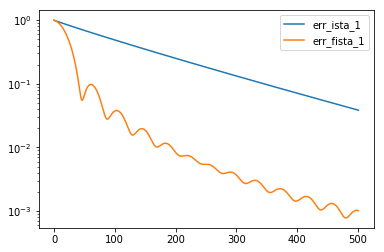

In [31]:
#_, objf, err_fista=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
_,obji, err_ista_1=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=500, x_true=x_fista, verbose=True)
_,objf, err_fista_1=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=500, x_true=x_fista, verbose=True)
plt.plot(err_ista_1, label='err_ista_1')
plt.plot(err_fista_1, label='err_fista_1')
plt.legend()
plt.yscale('log')

In [37]:
err_ista_1[:5], err_fista_1[:5]

([1.0,
  0.9922494679734823,
  0.9846005674202508,
  0.9770493372252154,
  0.9695920992182023],
 array([1.  , 0.99, 0.98, 0.97, 0.96]))

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with ista and fista with the true parameter `coefs` of
  the model. This can be done with `plt.stem` plots.</li>
    <li>In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.</li>
    <li>In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain</li>
    </ul>
</div>

### Compare the solution you obtain with ista and fista with the true parameter `coefs` of the model. This can be done with `plt.stem` plots.

(-2, 2)

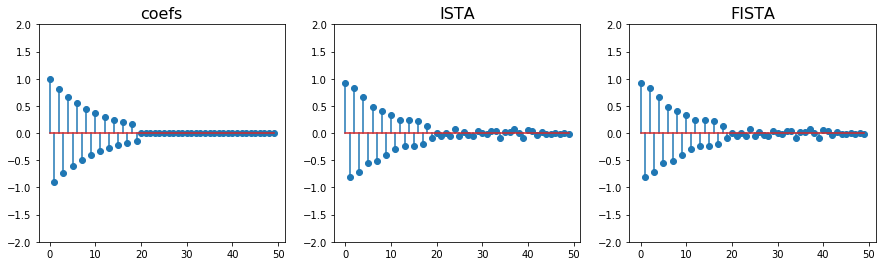

In [33]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(coefs)
plt.title("coefs", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(x_ista)
plt.title("ISTA", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(x_fista)
plt.title("FISTA", fontsize=16)
plt.ylim([-2, 2])


### In linear regression and logistic regression, study the influence of the correlation of the features on the performance of the optimization algorithms. Explain.

In [109]:
A,b=simu_logreg(coefs, n_samples=1000, corr=0.5)

f=loss_logreg
g=ridge
g_1=lasso
grad_f=grad_logreg
prox_g=prox_ridge
prox_g_1=prox_lasso
step=1/lip_logreg(A) # for logistic loss
#fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=1000, x_true=coefs, verbose=True)

_, obji_log, err_ista_log=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, objf_log, err_fista_log=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, _, err_ista_log_lasso=ista(x0, f, grad_f, g_1, prox_g_1, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, _, err_fista_log_lasso=fista(x0, f, grad_f, g_1, prox_g_1, step, s, n_iter=1000, x_true=coefs, verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 6.90e-01 | 9.94e-01
      10 | 6.62e-01 | 9.42e-01
      20 | 6.42e-01 | 8.95e-01
      30 | 6.26e-01 | 8.53e-01
      40 | 6.13e-01 | 8.14e-01
      50 | 6.03e-01 | 7.78e-01
      60 | 5.94e-01 | 7.45e-01
      70 | 5.86e-01 | 7.14e-01
      80 | 5.79e-01 | 6.86e-01
      90 | 5.74e-01 | 6.60e-01
     100 | 5.68e-01 | 6.35e-01
     110 | 5.64e-01 | 6.12e-01
     120 | 5.60e-01 | 5.91e-01
     130 | 5.57e-01 | 5.71e-01
     140 | 5.54e-01 | 5.52e-01
     150 | 5.51e-01 | 5.35e-01
     160 | 5.48e-01 | 5.18e-01
     170 | 5.46e-01 | 5.03e-01
     180 | 5.44e-01 | 4.88e-01
     190 | 5.43e-01 | 4.75e-01
     200 | 5.41e-01 | 4.62e-01
     210 | 5.40e-01 | 4.50e-01
     220 | 5.38e-01 | 4.39e-01
     230 | 5.37e-01 | 4.28e-01
     240 | 5.36e-01 | 4.18e-01
     250 | 5.35e-01 | 4.09e-01
     260 | 5.34e-01 | 4.00e-01
     270 | 5.33e-01 | 3.92e-01
     280 | 5.33e-01 | 3.84e-01
     290 | 5.32e-01 | 3.77e-01
     300 | 5.31

     590 | 5.87e-01 | 4.01e-01
     600 | 5.87e-01 | 4.00e-01
     610 | 5.87e-01 | 3.98e-01
     620 | 5.87e-01 | 3.97e-01
     630 | 5.87e-01 | 3.96e-01
     640 | 5.87e-01 | 3.94e-01
     650 | 5.87e-01 | 3.93e-01
     660 | 5.87e-01 | 3.92e-01
     670 | 5.86e-01 | 3.91e-01
     680 | 5.86e-01 | 3.90e-01
     690 | 5.86e-01 | 3.89e-01
     700 | 5.86e-01 | 3.88e-01
     710 | 5.86e-01 | 3.87e-01
     720 | 5.86e-01 | 3.86e-01
     730 | 5.86e-01 | 3.85e-01
     740 | 5.86e-01 | 3.85e-01
     750 | 5.86e-01 | 3.84e-01
     760 | 5.86e-01 | 3.83e-01
     770 | 5.86e-01 | 3.82e-01
     780 | 5.86e-01 | 3.82e-01
     790 | 5.86e-01 | 3.81e-01
     800 | 5.86e-01 | 3.80e-01
     810 | 5.86e-01 | 3.80e-01
     820 | 5.86e-01 | 3.79e-01
     830 | 5.86e-01 | 3.79e-01
     840 | 5.86e-01 | 3.78e-01
     850 | 5.86e-01 | 3.78e-01
     860 | 5.86e-01 | 3.77e-01
     870 | 5.86e-01 | 3.77e-01
     880 | 5.86e-01 | 3.76e-01
     890 | 5.86e-01 | 3.76e-01
     900 | 5.86e-01 | 3.75e-01
     910

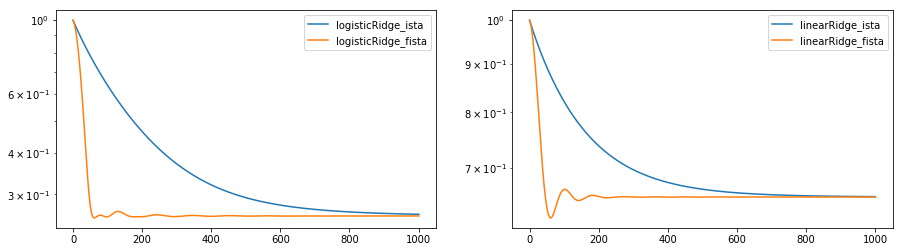

In [110]:
plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 2, 1)
plt.plot(err_ista_log, label='logisticRidge_ista')
plt.plot(err_fista_log, label='logisticRidge_fista')
plt.legend()
plt.yscale('log')
#plt.title("Original parameter", fontsize=16)
#plt.ylim([-2, 2])
plt.subplot(1, 2, 2)

plt.plot(err_ista, label='linearRidge_ista')
plt.plot(err_fista, label='linearRidge_fista')
plt.legend()
plt.yscale('log')
#plt.title("Proximal Lasso", fontsize=16)
#plt.ylim([-2, 2])

### In linear regression and logistic regression, study the influence of the level of ridge penalization on the performance of the optimization algorithms. Explain.

In [ ]:
# A,b=simu_linreg(coefs, n_samples=1000, corr=0.5)

# f=loss_linreg
# g=ridge
# g_1=lasso
# grad_f=grad_linreg
# prox_g=prox_ridge
# step=lip_linreg(A)
# prox_g_1=prox_lasso
# #Linear function
# "Regularizor is Ridge"
# _, objiR_lin, err_ista_lin=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
# _, objfR_lin, err_fista_lin=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)


# A,b=simu_logreg(coefs, n_samples=1000, corr=0.5)
# f=loss_logreg
# g=ridge
# g_1=lasso
# grad_f=grad_logreg
# prox_g=prox_ridge
# prox_g_1=prox_lasso
# step=lip_logreg(A) # for logistic loss

# #Function for logistic regression


# "Regularizor is Ridge"
# _, obji_log, err_ista_log=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
# _, objf_log, err_fista_log=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)

In [141]:
sa=np.array([1,2,0,6,7,0,7])
sa.argmin()

2

In [142]:
A,b=simu_linreg(coefs, n_samples=1000, corr=0.5)

f=loss_linreg
g=ridge
g_1=lasso
grad_f=grad_linreg
prox_g=prox_ridge
step=1/lip_linreg(A)
prox_g_1=prox_lasso
#Linear function
"Regularizor is Ridge, linear"
#_, objiR_lin, err_ista_lin=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
errors=[]
for s in 10**(-np.linspace(0,1, 10)):
    _, objiR_lin, err_ista_lin=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
    errors.append((np.array(err_ista_lin).argmin(), np.array(err_ista_lin).min()))




A,b=simu_logreg(coefs, n_samples=1000, corr=0.5)
f=loss_logreg
g=ridge
g_1=lasso
grad_f=grad_logreg
prox_g=prox_ridge
prox_g_1=prox_lasso
step=1/lip_logreg(A) # for logistic loss

#Function for logistic regression


"Regularizor is Ridge, logistic"
error=[]
for s in 10**(-np.linspace(0,1, 10)):
    x_, obji_log, err_ista_log=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
    error.append((np.array(err_ista_log).argmin(), np.array(err_ista_log).min()))



Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.44e+00 | 9.93e-01
      10 | 1.31e+00 | 9.34e-01
      20 | 1.25e+00 | 8.90e-01
      30 | 1.21e+00 | 8.57e-01
      40 | 1.20e+00 | 8.33e-01
      50 | 1.18e+00 | 8.14e-01
      60 | 1.18e+00 | 7.99e-01
      70 | 1.18e+00 | 7.88e-01
      80 | 1.17e+00 | 7.80e-01
      90 | 1.17e+00 | 7.74e-01
     100 | 1.17e+00 | 7.69e-01
     110 | 1.17e+00 | 7.65e-01
     120 | 1.17e+00 | 7.62e-01
     130 | 1.17e+00 | 7.60e-01
     140 | 1.17e+00 | 7.58e-01
     150 | 1.17e+00 | 7.57e-01
     160 | 1.17e+00 | 7.56e-01
     170 | 1.17e+00 | 7.55e-01
     180 | 1.17e+00 | 7.55e-01
     190 | 1.17e+00 | 7.54e-01
     200 | 1.17e+00 | 7.54e-01
     210 | 1.17e+00 | 7.54e-01
     220 | 1.17e+00 | 7.53e-01
     230 | 1.17e+00 | 7.53e-01
     240 | 1.17e+00 | 7.53e-01
     250 | 1.17e+00 | 7.53e-01
     260 | 1.17e+00 | 7.53e-01
     270 | 1.17e+00 | 7.53e-01
     280 | 1.17e+00 | 7.53e-01
     290 | 1.17e+00 | 7.53e-01
     300 | 1.17

     810 | 1.07e+00 | 6.52e-01
     820 | 1.07e+00 | 6.52e-01
     830 | 1.07e+00 | 6.52e-01
     840 | 1.07e+00 | 6.52e-01
     850 | 1.07e+00 | 6.52e-01
     860 | 1.07e+00 | 6.52e-01
     870 | 1.07e+00 | 6.52e-01
     880 | 1.07e+00 | 6.52e-01
     890 | 1.07e+00 | 6.52e-01
     900 | 1.07e+00 | 6.52e-01
     910 | 1.07e+00 | 6.52e-01
     920 | 1.07e+00 | 6.52e-01
     930 | 1.07e+00 | 6.52e-01
     940 | 1.07e+00 | 6.52e-01
     950 | 1.07e+00 | 6.52e-01
     960 | 1.07e+00 | 6.52e-01
     970 | 1.07e+00 | 6.52e-01
     980 | 1.07e+00 | 6.52e-01
     990 | 1.07e+00 | 6.52e-01
    1000 | 1.07e+00 | 6.52e-01
Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.44e+00 | 9.93e-01
      10 | 1.30e+00 | 9.30e-01
      20 | 1.21e+00 | 8.78e-01
      30 | 1.15e+00 | 8.35e-01
      40 | 1.11e+00 | 7.99e-01
      50 | 1.08e+00 | 7.68e-01
      60 | 1.06e+00 | 7.42e-01
      70 | 1.04e+00 | 7.20e-01
      80 | 1.03e+00 | 7.02e-01
      90 | 1.03e+00 | 6.86e-01
     100 | 1.02

      80 | 9.21e-01 | 6.50e-01
      90 | 9.04e-01 | 6.26e-01
     100 | 8.90e-01 | 6.04e-01
     110 | 8.80e-01 | 5.85e-01
     120 | 8.71e-01 | 5.68e-01
     130 | 8.64e-01 | 5.53e-01
     140 | 8.59e-01 | 5.39e-01
     150 | 8.54e-01 | 5.27e-01
     160 | 8.51e-01 | 5.16e-01
     170 | 8.48e-01 | 5.06e-01
     180 | 8.46e-01 | 4.98e-01
     190 | 8.44e-01 | 4.90e-01
     200 | 8.43e-01 | 4.83e-01
     210 | 8.41e-01 | 4.76e-01
     220 | 8.40e-01 | 4.71e-01
     230 | 8.40e-01 | 4.66e-01
     240 | 8.39e-01 | 4.61e-01
     250 | 8.39e-01 | 4.57e-01
     260 | 8.38e-01 | 4.53e-01
     270 | 8.38e-01 | 4.50e-01
     280 | 8.38e-01 | 4.47e-01
     290 | 8.37e-01 | 4.44e-01
     300 | 8.37e-01 | 4.42e-01
     310 | 8.37e-01 | 4.40e-01
     320 | 8.37e-01 | 4.38e-01
     330 | 8.37e-01 | 4.36e-01
     340 | 8.37e-01 | 4.35e-01
     350 | 8.37e-01 | 4.33e-01
     360 | 8.37e-01 | 4.32e-01
     370 | 8.37e-01 | 4.31e-01
     380 | 8.37e-01 | 4.30e-01
     390 | 8.37e-01 | 4.29e-01
     400

     500 | 6.95e-01 | 2.87e-01
     510 | 6.94e-01 | 2.86e-01
     520 | 6.94e-01 | 2.86e-01
     530 | 6.94e-01 | 2.85e-01
     540 | 6.94e-01 | 2.84e-01
     550 | 6.94e-01 | 2.84e-01
     560 | 6.94e-01 | 2.83e-01
     570 | 6.94e-01 | 2.83e-01
     580 | 6.94e-01 | 2.82e-01
     590 | 6.94e-01 | 2.82e-01
     600 | 6.94e-01 | 2.81e-01
     610 | 6.94e-01 | 2.81e-01
     620 | 6.94e-01 | 2.81e-01
     630 | 6.94e-01 | 2.81e-01
     640 | 6.94e-01 | 2.80e-01
     650 | 6.94e-01 | 2.80e-01
     660 | 6.94e-01 | 2.80e-01
     670 | 6.94e-01 | 2.80e-01
     680 | 6.94e-01 | 2.79e-01
     690 | 6.94e-01 | 2.79e-01
     700 | 6.94e-01 | 2.79e-01
     710 | 6.94e-01 | 2.79e-01
     720 | 6.94e-01 | 2.79e-01
     730 | 6.94e-01 | 2.79e-01
     740 | 6.94e-01 | 2.78e-01
     750 | 6.94e-01 | 2.78e-01
     760 | 6.94e-01 | 2.78e-01
     770 | 6.94e-01 | 2.78e-01
     780 | 6.94e-01 | 2.78e-01
     790 | 6.94e-01 | 2.78e-01
     800 | 6.94e-01 | 2.78e-01
     810 | 6.94e-01 | 2.78e-01
     820

      60 | 6.66e-01 | 9.04e-01
      70 | 6.66e-01 | 9.03e-01
      80 | 6.66e-01 | 9.02e-01
      90 | 6.66e-01 | 9.01e-01
     100 | 6.66e-01 | 9.01e-01
     110 | 6.66e-01 | 9.01e-01
     120 | 6.66e-01 | 9.01e-01
     130 | 6.66e-01 | 9.01e-01
     140 | 6.66e-01 | 9.01e-01
     150 | 6.66e-01 | 9.01e-01
     160 | 6.66e-01 | 9.01e-01
     170 | 6.66e-01 | 9.01e-01
     180 | 6.66e-01 | 9.01e-01
     190 | 6.66e-01 | 9.01e-01
     200 | 6.66e-01 | 9.01e-01
     210 | 6.66e-01 | 9.01e-01
     220 | 6.66e-01 | 9.01e-01
     230 | 6.66e-01 | 9.01e-01
     240 | 6.66e-01 | 9.01e-01
     250 | 6.66e-01 | 9.01e-01
     260 | 6.66e-01 | 9.01e-01
     270 | 6.66e-01 | 9.01e-01
     280 | 6.66e-01 | 9.01e-01
     290 | 6.66e-01 | 9.01e-01
     300 | 6.66e-01 | 9.01e-01
     310 | 6.66e-01 | 9.01e-01
     320 | 6.66e-01 | 9.01e-01
     330 | 6.66e-01 | 9.01e-01
     340 | 6.66e-01 | 9.01e-01
     350 | 6.66e-01 | 9.01e-01
     360 | 6.66e-01 | 9.01e-01
     370 | 6.66e-01 | 9.01e-01
     380

     670 | 6.53e-01 | 8.49e-01
     680 | 6.53e-01 | 8.49e-01
     690 | 6.53e-01 | 8.49e-01
     700 | 6.53e-01 | 8.49e-01
     710 | 6.53e-01 | 8.49e-01
     720 | 6.53e-01 | 8.49e-01
     730 | 6.53e-01 | 8.49e-01
     740 | 6.53e-01 | 8.49e-01
     750 | 6.53e-01 | 8.49e-01
     760 | 6.53e-01 | 8.49e-01
     770 | 6.53e-01 | 8.49e-01
     780 | 6.53e-01 | 8.49e-01
     790 | 6.53e-01 | 8.49e-01
     800 | 6.53e-01 | 8.49e-01
     810 | 6.53e-01 | 8.49e-01
     820 | 6.53e-01 | 8.49e-01
     830 | 6.53e-01 | 8.49e-01
     840 | 6.53e-01 | 8.49e-01
     850 | 6.53e-01 | 8.49e-01
     860 | 6.53e-01 | 8.49e-01
     870 | 6.53e-01 | 8.49e-01
     880 | 6.53e-01 | 8.49e-01
     890 | 6.53e-01 | 8.49e-01
     900 | 6.53e-01 | 8.49e-01
     910 | 6.53e-01 | 8.49e-01
     920 | 6.53e-01 | 8.49e-01
     930 | 6.53e-01 | 8.49e-01
     940 | 6.53e-01 | 8.49e-01
     950 | 6.53e-01 | 8.49e-01
     960 | 6.53e-01 | 8.49e-01
     970 | 6.53e-01 | 8.49e-01
     980 | 6.53e-01 | 8.49e-01
     990

     250 | 6.27e-01 | 7.40e-01
     260 | 6.27e-01 | 7.39e-01
     270 | 6.27e-01 | 7.39e-01
     280 | 6.27e-01 | 7.39e-01
     290 | 6.27e-01 | 7.39e-01
     300 | 6.27e-01 | 7.39e-01
     310 | 6.27e-01 | 7.39e-01
     320 | 6.27e-01 | 7.38e-01
     330 | 6.27e-01 | 7.38e-01
     340 | 6.27e-01 | 7.38e-01
     350 | 6.27e-01 | 7.38e-01
     360 | 6.27e-01 | 7.38e-01
     370 | 6.27e-01 | 7.38e-01
     380 | 6.27e-01 | 7.38e-01
     390 | 6.27e-01 | 7.38e-01
     400 | 6.27e-01 | 7.38e-01
     410 | 6.27e-01 | 7.38e-01
     420 | 6.27e-01 | 7.38e-01
     430 | 6.27e-01 | 7.38e-01
     440 | 6.27e-01 | 7.38e-01
     450 | 6.27e-01 | 7.38e-01
     460 | 6.27e-01 | 7.38e-01
     470 | 6.27e-01 | 7.38e-01
     480 | 6.27e-01 | 7.38e-01
     490 | 6.27e-01 | 7.38e-01
     500 | 6.27e-01 | 7.38e-01
     510 | 6.27e-01 | 7.38e-01
     520 | 6.27e-01 | 7.38e-01
     530 | 6.27e-01 | 7.38e-01
     540 | 6.27e-01 | 7.38e-01
     550 | 6.27e-01 | 7.38e-01
     560 | 6.27e-01 | 7.38e-01
     570

     840 | 6.06e-01 | 6.43e-01
     850 | 6.06e-01 | 6.43e-01
     860 | 6.06e-01 | 6.43e-01
     870 | 6.06e-01 | 6.43e-01
     880 | 6.06e-01 | 6.43e-01
     890 | 6.06e-01 | 6.43e-01
     900 | 6.06e-01 | 6.43e-01
     910 | 6.06e-01 | 6.43e-01
     920 | 6.06e-01 | 6.43e-01
     930 | 6.06e-01 | 6.43e-01
     940 | 6.06e-01 | 6.43e-01
     950 | 6.06e-01 | 6.43e-01
     960 | 6.06e-01 | 6.43e-01
     970 | 6.06e-01 | 6.43e-01
     980 | 6.06e-01 | 6.43e-01
     990 | 6.06e-01 | 6.43e-01
    1000 | 6.06e-01 | 6.43e-01


In [160]:
np.array(error)[:,0]

array([ 403.,  495.,  643.,  789.,  966., 1001., 1001., 1001., 1001.,
       1001.])

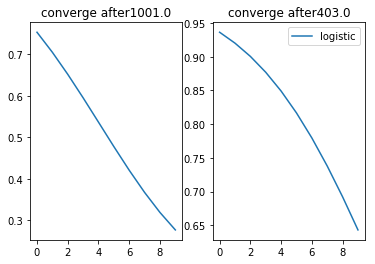

In [161]:
plt.subplot(1,2,1)
plt.plot(np.array(errors)[:,1], label= 'linear')
plt.title('converge after%s'%np.array(errors)[:,0].min())
plt.subplot(1,2,2)
plt.plot(np.array(error)[:,1], label= 'logistic')
plt.title('converge after%s'%np.array(error)[:,0].min())
plt.legend()
#plt.xlabel('level of regularization')

We observe a convergence more faster from logistic regression , whith linear which seem to be convex and logistic concave. errors decrease  when the value of level regularizer is low.

Text(0.5, 1.0, 'obj with penalizer Ridge for (Logistic & Linear| FISTA)')

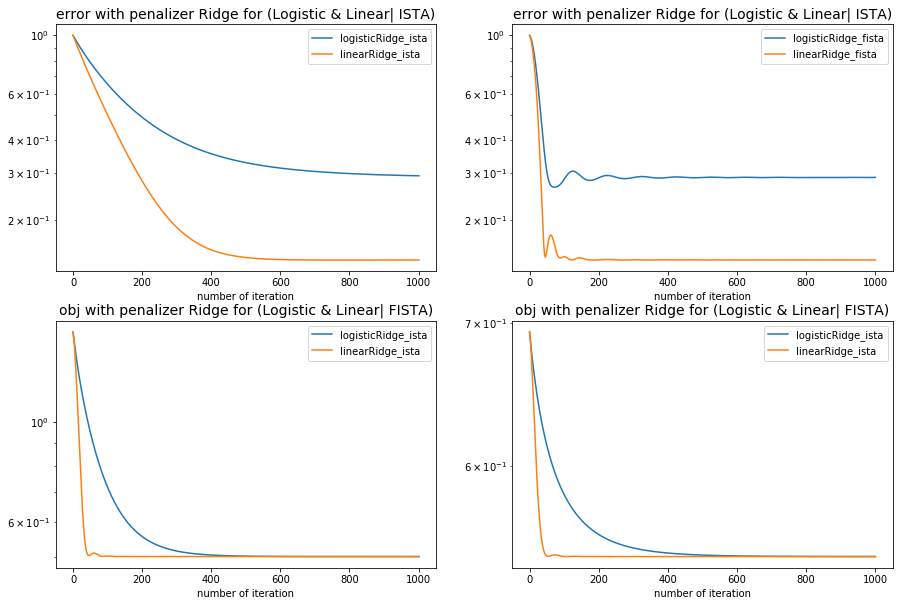

In [122]:
plt.figure(figsize=(15.0, 10))
plt.subplot(2, 2, 1)
plt.plot(err_ista_log, label='logisticRidge_ista')
plt.plot(err_ista_lin, label='linearRidge_ista')
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")

plt.title("error with penalizer Ridge for (Logistic & Linear| ISTA)", fontsize=14)
#plt.title("Original parameter", fontsize=16)
#plt.ylim([-2, 2])
plt.subplot(2, 2, 2)

plt.plot(err_fista_log, label='logisticRidge_fista')
plt.plot(err_fista_lin, label='linearRidge_fista')
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")
plt.title("error with penalizer Ridge for (Logistic & Linear| ISTA)", fontsize=14)

plt.subplot(2, 2, 3)
" in Fista" 
plt.plot(objiR_lin, label='logisticRidge_ista')
plt.plot(objfR_lin, label='linearRidge_ista')
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")

plt.title("obj with penalizer Ridge for (Logistic & Linear| FISTA)", fontsize=14)

plt.subplot(2, 2, 4)
plt.plot(obji_log, label='logisticRidge_ista')
plt.plot(objf_log, label='linearRidge_ista')
plt.legend()
plt.yscale('log')
plt.xlabel("number of iteration")

plt.title("obj with penalizer Ridge for (Logistic & Linear| FISTA)", fontsize=14)
#plt.ylim([-2, 2])

### In linear regression and logistic regression, compare the performance of the optimization algorithms for ridge and lasso penalizations. Explain

In [111]:
A,b=simu_linreg(coefs, n_samples=1000, corr=0.5)

f=loss_linreg
g=ridge
g_1=lasso
grad_f=grad_linreg
prox_g=prox_ridge
step=1/lip_linreg(A)
prox_g_1=prox_lasso
#Linear function
"Regularizor is Ridge"
_, objiR_lin, err_ista_lin=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, objfR_lin, err_fista_lin=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
"Regularizor is lasso"
_, objiL_lin, err_ista_lin_lasso=ista(x0, f, grad_f, g_1, prox_g_1, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, objiL_lin, err_fista_lin_lasso=fista(x0, f, grad_f, g_1, prox_g_1, step, s, n_iter=1000, x_true=coefs, verbose=True)
# _, obji, err_ista=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
# _, objf, err_fista=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)

Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 1.57e+00 | 9.92e-01
      10 | 1.37e+00 | 9.18e-01
      20 | 1.22e+00 | 8.53e-01
      30 | 1.11e+00 | 7.93e-01
      40 | 1.02e+00 | 7.39e-01
      50 | 9.44e-01 | 6.90e-01
      60 | 8.81e-01 | 6.45e-01
      70 | 8.28e-01 | 6.03e-01
      80 | 7.84e-01 | 5.65e-01
      90 | 7.46e-01 | 5.29e-01
     100 | 7.13e-01 | 4.96e-01
     110 | 6.85e-01 | 4.66e-01
     120 | 6.61e-01 | 4.38e-01
     130 | 6.41e-01 | 4.12e-01
     140 | 6.23e-01 | 3.89e-01
     150 | 6.07e-01 | 3.67e-01
     160 | 5.94e-01 | 3.46e-01
     170 | 5.82e-01 | 3.27e-01
     180 | 5.72e-01 | 3.10e-01
     190 | 5.63e-01 | 2.94e-01
     200 | 5.55e-01 | 2.80e-01
     210 | 5.48e-01 | 2.66e-01
     220 | 5.42e-01 | 2.54e-01
     230 | 5.37e-01 | 2.42e-01
     240 | 5.33e-01 | 2.32e-01
     250 | 5.29e-01 | 2.23e-01
     260 | 5.26e-01 | 2.14e-01
     270 | 5.23e-01 | 2.06e-01
     280 | 5.20e-01 | 1.99e-01
     290 | 5.18e-01 | 1.93e-01
     300 | 5.16

In [112]:
A,b=simu_logreg(coefs, n_samples=1000, corr=0.5)


f=loss_logreg
g=ridge
g_1=lasso
grad_f=grad_logreg
prox_g=prox_ridge
prox_g_1=prox_lasso
step=1/lip_logreg(A) # for logistic loss

#Function for logistic regression


"Regularizor is Ridge"
_, obji_log, err_ista_log=ista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, objf_log, err_fista_log=fista(x0, f, grad_f, g, prox_g, step, s, n_iter=1000, x_true=coefs, verbose=True)
"Regularizor is lasso"
_, _, err_ista_log_lasso=ista(x0, f, grad_f, g_1, prox_g_1, step, s, n_iter=1000, x_true=coefs, verbose=True)
_, _, err_fista_log_lasso=fista(x0, f, grad_f, g_1, prox_g_1, step, s, n_iter=1000, x_true=coefs, verbose=True)





Lauching ISTA solver...
   it    |   obj    |   err   
       0 | 6.90e-01 | 9.95e-01
      10 | 6.67e-01 | 9.45e-01
      20 | 6.49e-01 | 8.99e-01
      30 | 6.34e-01 | 8.58e-01
      40 | 6.23e-01 | 8.21e-01
      50 | 6.13e-01 | 7.87e-01
      60 | 6.04e-01 | 7.55e-01
      70 | 5.97e-01 | 7.26e-01
      80 | 5.91e-01 | 6.99e-01
      90 | 5.86e-01 | 6.74e-01
     100 | 5.82e-01 | 6.51e-01
     110 | 5.78e-01 | 6.30e-01
     120 | 5.74e-01 | 6.09e-01
     130 | 5.71e-01 | 5.91e-01
     140 | 5.69e-01 | 5.73e-01
     150 | 5.66e-01 | 5.56e-01
     160 | 5.64e-01 | 5.41e-01
     170 | 5.62e-01 | 5.27e-01
     180 | 5.60e-01 | 5.13e-01
     190 | 5.59e-01 | 5.00e-01
     200 | 5.58e-01 | 4.89e-01
     210 | 5.56e-01 | 4.77e-01
     220 | 5.55e-01 | 4.67e-01
     230 | 5.54e-01 | 4.57e-01
     240 | 5.53e-01 | 4.48e-01
     250 | 5.53e-01 | 4.39e-01
     260 | 5.52e-01 | 4.31e-01
     270 | 5.51e-01 | 4.23e-01
     280 | 5.51e-01 | 4.16e-01
     290 | 5.50e-01 | 4.09e-01
     300 | 5.50

     590 | 6.01e-01 | 4.42e-01
     600 | 6.01e-01 | 4.41e-01
     610 | 6.01e-01 | 4.40e-01
     620 | 6.01e-01 | 4.39e-01
     630 | 6.01e-01 | 4.38e-01
     640 | 6.01e-01 | 4.36e-01
     650 | 6.01e-01 | 4.35e-01
     660 | 6.01e-01 | 4.34e-01
     670 | 6.01e-01 | 4.33e-01
     680 | 6.01e-01 | 4.33e-01
     690 | 6.01e-01 | 4.32e-01
     700 | 6.01e-01 | 4.31e-01
     710 | 6.01e-01 | 4.30e-01
     720 | 6.01e-01 | 4.29e-01
     730 | 6.01e-01 | 4.29e-01
     740 | 6.01e-01 | 4.28e-01
     750 | 6.01e-01 | 4.27e-01
     760 | 6.01e-01 | 4.27e-01
     770 | 6.01e-01 | 4.26e-01
     780 | 6.01e-01 | 4.25e-01
     790 | 6.01e-01 | 4.25e-01
     800 | 6.01e-01 | 4.24e-01
     810 | 6.01e-01 | 4.24e-01
     820 | 6.01e-01 | 4.23e-01
     830 | 6.01e-01 | 4.23e-01
     840 | 6.01e-01 | 4.23e-01
     850 | 6.01e-01 | 4.22e-01
     860 | 6.01e-01 | 4.22e-01
     870 | 6.01e-01 | 4.21e-01
     880 | 6.01e-01 | 4.21e-01
     890 | 6.01e-01 | 4.21e-01
     900 | 6.01e-01 | 4.20e-01
     910

Text(0.5, 1.0, 'error in logistic regression for (Ridge & Lasso| FISTA)')

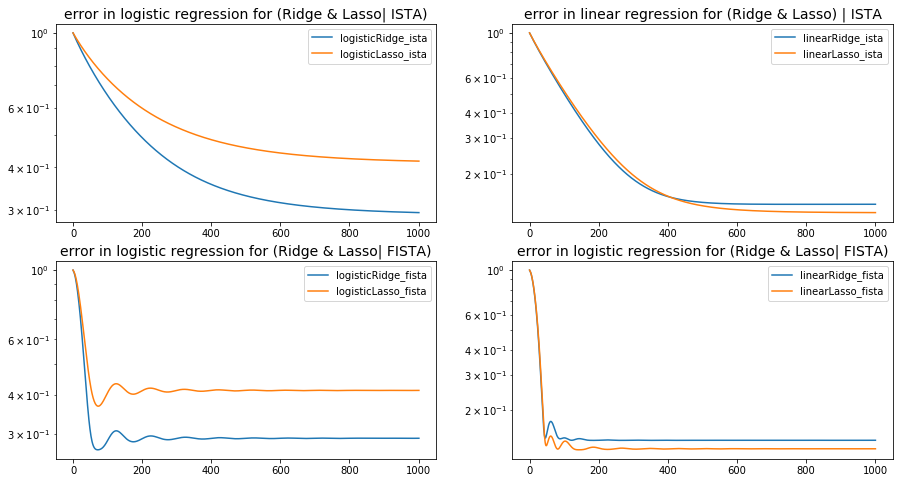

In [116]:
plt.figure(figsize=(15.0, 8))
plt.subplot(2, 2, 1)
plt.plot(err_ista_log, label='logisticRidge_ista')
plt.plot(err_ista_log_lasso, label='logisticLasso_ista')
plt.legend()
plt.yscale('log')

plt.title("error in logistic regression for (Ridge & Lasso| ISTA)", fontsize=14)
#plt.title("Original parameter", fontsize=16)
#plt.ylim([-2, 2])
plt.subplot(2, 2, 2)

plt.plot(err_ista_lin, label='linearRidge_ista')
plt.plot(err_ista_lin_lasso, label='linearLasso_ista')

plt.legend()
plt.yscale('log')
plt.title("error in linear regression for (Ridge & Lasso) | ISTA", fontsize=14)

plt.subplot(2, 2, 3)
" in Fista" 
plt.plot(err_fista_log, label='logisticRidge_fista')
plt.plot(err_fista_log_lasso, label='logisticLasso_fista')
plt.legend()
plt.yscale('log')
plt.title("error in logistic regression for (Ridge & Lasso| FISTA)", fontsize=14)

plt.subplot(2, 2, 4)
plt.plot(err_fista_lin, label='linearRidge_fista')
plt.plot(err_fista_lin_lasso, label='linearLasso_fista')
plt.legend()
plt.yscale('log')
plt.title("error in logistic regression for (Ridge & Lasso| FISTA)", fontsize=14)
#plt.ylim([-2, 2])